Test out SVD on the Latin Hypercube Design $P_0(k)$s

In [1]:
import numpy as np 
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.utils.extmath import svd_flip

# -- local -- 
import env
from specmulator import emulator as Emu
from specmulator import onlyhod as onlyHOD

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Calculate $\overline{P(k|\theta_i)}$ for $\theta_i \in \{LHD\}$ from 10 realizations

In [3]:
X_lhd = [] 
for i in range(1,11): 
    k_arr, X_lhd_i = onlyHOD.X_HODLHD(i, prior='sinha2017prior_narrow', samples=40, method='mdu', karr=True)
    X_lhd.append(X_lhd_i)
X_lhd = np.mean(np.array(X_lhd), axis=0)

In [4]:
print(X_lhd.shape)

(39, 112)


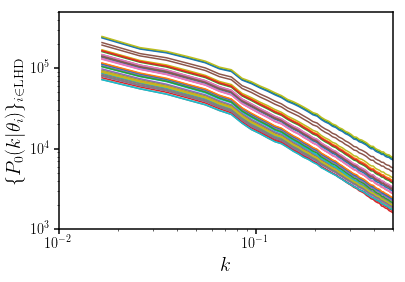

In [5]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(X_lhd.shape[0]): 
    sub.plot(k_arr, X_lhd[i,:])
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel(r'$\{P_0(k|\theta_i)\}_{i \in \mathrm{LHD}}$', fontsize=20)
sub.set_ylim([10**3, 5e5])
sub.set_yscale('log')

mean subtract and whiten the data

In [6]:
dX_lhd = (X_lhd - np.mean(X_lhd, axis=0))/np.std(X_lhd, axis=0)

Text(0,0.5,'$\\{P_0(k|\\theta_i)\\}_{i \\in \\mathrm{LHD}}$')

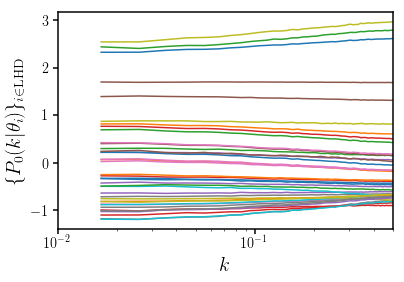

In [7]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(X_lhd.shape[0]): 
    sub.plot(k_arr, dX_lhd[i,:])
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel(r'$\{P_0(k|\theta_i)\}_{i \in \mathrm{LHD}}$', fontsize=20)
#sub.set_ylim([10**3, 5e5])
#sub.set_yscale('log')

single valud decompose the whitened data

In [23]:
n_comp = 10

In [24]:
svd = Emu.Svd(n_comp=n_comp)
U, sigma, V = svd.fit(X_lhd)

In [25]:
# principal component
pc = svd.transform(X_lhd)
#pc = np.dot(U, np.diag(sigma))/np.sqrt(len(sigma))
# principal compoent weight
#w_pc = np.sqrt(len(sigma)) * V

In [26]:
#explained_variance_ = (sigma ** 2) / (dX_lhd.shape[0] - 1)
print(svd.exp_var_ratio)

[9.96039955e-01 3.33944841e-03 6.05698271e-04 1.03653791e-05
 1.74092973e-06 5.38772547e-07 3.42343548e-07 2.92506374e-07
 2.79215761e-07 1.70989336e-07]


Check we can reconstruct the data from the principal components 

(39, 112)


Text(0,0.5,'reconstructed $\\{P_0(k|\\theta_i)\\}_{i \\in \\mathrm{LHD}}$')

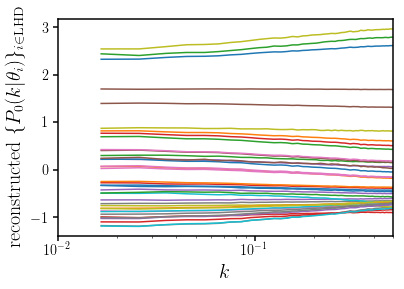

In [27]:
dX_recon = svd._white(svd.inv_transform(pc)) #np.dot(pc[:,:n_comp], w_pc[:n_comp,:])
print dX_recon.shape
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(X_lhd.shape[0]): 
    sub.plot(k_arr, dX_recon[i,:].T)
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel(r'reconstructed $\{P_0(k|\theta_i)\}_{i \in \mathrm{LHD}}$', fontsize=20)

Lets look at the residual of the reconstructed to the actual data

(-0.01, 0.01)

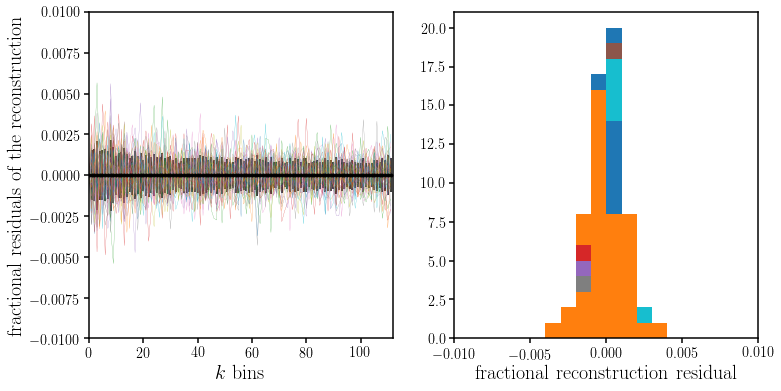

In [29]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)

for i in range(X_lhd.shape[0]): 
    sub.plot(range(X_lhd.shape[1]), (dX_recon[i,:]-dX_lhd[i,:]).T, lw=0.2)
X_resid = np.mean(dX_recon-dX_lhd, axis=0) 
sig_resid = np.std(dX_recon-dX_lhd, axis=0, ddof=1)
sub.errorbar(range(X_lhd.shape[1]), X_resid, yerr=sig_resid, fmt='.k')
sub.set_xlabel(r'$k$ bins', fontsize=20)
sub.set_xlim([0., X_lhd.shape[1]])
sub.set_ylabel(r'fractional residuals of the reconstruction', fontsize=20)
sub.set_ylim([-0.01,0.01])

sub = fig.add_subplot(122)
for i in range(dX_lhd.shape[1])[::10]:
    _ = sub.hist((dX_recon[:,i]-dX_lhd[:,i]).T, bins=20, range=[-0.01, 0.01], linewidth=2)
sub.set_xlabel('fractional reconstruction residual', fontsize=20)
sub.set_xlim([-0.01, 0.01])

even with 5 principal components, does pretty well